In [133]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import scatter
from arch.unitroot import PhillipsPerron
from scipy.stats import kstest
from scipy.stats import jarque_bera
import statsmodels.api as sm
import math
import pandas as pd
import seaborn as sns

import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [140]:
## Definição das Classes

class Etl:
        
    def __init__(self, df):
            
        self.df = df
    
    def date_transformation_and_aggregation(self):

        ## Transformando de datetime para date
        
        df = self.df

        df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
        df['order_purchase_timestamp'].dtype

        df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.date
        df['order_purchase_timestamp']
        
        ## Agregando o preço por data

        df = df.groupby("order_purchase_timestamp").price.sum()

        ## Retransformando em dataframe

        df = df.to_frame()
        
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.plot(df)
        
        return df
    
    def remove_outliers(self, upper_limit_quantile, lower_limit_quantile):

        df = self.df
        
        ## Preenchendo as datas faltantes com vendas nulas

        df = df.asfreq(freq='1D', fill_value = 0)

        ## Dropando valores nulos do início da série
        df = df.loc['2017-01-05':'2018-08-27']
        
        ## Aqui, será utilizado percentil de 0.98 para remover todos os outliers

        upper_limit = df['price'].quantile(upper_limit_quantile)
        lower_limit = df['price'].quantile(lower_limit_quantile)

        df['price'] = np.where((df['price'] < lower_limit),
                lower_limit,
                np.where((df['price'] > upper_limit),
                upper_limit,
                df['price']))
        
        ## Preenchendo com valores 0

        df = df.asfreq(freq='1D', fill_value = 0)
        df.interpolate(inplace=True)
        
        return df


class Params:
    
    def __init__(self, df, target_column):
        
        self.df = df
        self.target_column = target_column
    
    def param_train_test_split(self):
        
        ## Dividindo o dataset entre treino e teste
        
        df_train, df_test = train_test_split(self.df, train_size=480)
        return df_train, df_test
    
    def param_differentiation(self):
        
        df_train, df_test = self.param_train_test_split()
        
        df_diff = self.df.diff()
        df_train_diff = df_train.diff()
        df_test_diff = df_test.diff()
        
        return df_diff, df_train_diff, df_test_diff

class Models(Params):
    
    def __init__(self, df, target_column):
        
        super().__init__(df, target_column)

    def acf_and_pacf(self):

        df_col = self.df[self.target_column]
        
        df_col.replace([np.inf, -np.inf], np.nan)
        df_col.dropna(inplace=True)

        plot_acf(df_col, lags=30, zero=False)
        plot_pacf(df_col, lags=30, zero=False)
        plt.show()
    
    def arima_model(self, p, d, q):
        
        df_train, df_test = self.param_train_test_split()
        
        arima_column = df_train[self.target_column]
        
        arima = ARIMA(arima_column, freq='D', order = (p,d,q))
        result_AR = arima.fit()
        (result_AR.resid**2).mean()
        forecast = result_AR.forecast(steps=120)
        return result_AR, forecast
    
    def sarima_model(self, p, d, q, P, D, Q):
               
        df_train, df_test = self.param_train_test_split()
        
        sarima_column = df_train[self.target_column]
        
        result_SAR = sm.tsa.statespace.SARIMAX(sarima_column, freq = 'D', order = (p ,d, q), seasonal_order=(P, D, Q, 7)).fit()
        forecast = result_SAR.forecast(steps=120)
        return result_SAR, forecast
    
class Error(Params):
    
    def __init__(self, df, target_column):
        
        super().__init__(df, target_column)

    def rmse(self, forecast):
        
        df_train, df_test = self.param_train_test_split()

        y_actual = df_test.squeeze()
        y_predicted = forecast.squeeze()

        MSE = 0

        for i in range(len(y_actual)):
            MSE += np.square(np.subtract(y_actual[i],y_predicted[i]))

        MSE = MSE/len(y_actual)
        RMSE = math.sqrt(MSE)
        print("Root Mean Square Error:\n")
        print(RMSE)
        
        ## Erro MAE

    def mae(self, forecast):
        
        df_train, df_test = self.param_train_test_split()
        
        y_actual = df_test.squeeze()
        y_predicted = forecast.squeeze()

        MAE = 0

        for i in range(len(y_actual)):
            MAE += np.sqrt(np.power((np.subtract(y_actual[i],y_predicted[i])),2))

        MAE = MAE/len(y_actual)

        print("Mean Absolute Error:\n")
        print(MAE)
        
class Stationarity:
    
    def __init__(self, df, target_column):
        
        self.df = df
        self.target_column = target_column
    
    ## Teste de Dickey-Fuller
    
    def dickey_fuller(self):
        
        
        dickey_fuller_col = self.df[self.target_column]

        dickey_fuller_col.replace([np.inf, -np.inf], np.nan)
        dickey_fuller_col.dropna(inplace=True)

        print ('Result of Fuller test:')

        dftest = adfuller(dickey_fuller_col, autolag='AIC')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Number of observations Used'])

        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key]= value
        print("Dickey-Fuller test:\n")
        print(dfoutput)
        print("\n")
    
    ## Teste KPSS
    def kpss(self):
        
        kpss_column = self.df[self.target_column]

        kpss_column.replace([np.inf, -np.inf], np.nan)
        kpss_column.dropna(inplace=True)

        kpss_input = kpss(kpss_column)
        kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
        kpss_test = round(kpss_test,4)

        for key, value in kpss_input[3].items():
            kpss_test["Valores Críticos (%s)"%key] = value
        print("KPSS test:\n")
        print(kpss_test)
        print("\n")
        
    def augmented_dickey_fuller(self):
        
        ## Dickey-Fuller aumentado
        
        adf_col = self.df[self.target_column]
        
        adf_col.replace([np.inf, -np.inf], np.nan)
        adf_col.dropna(inplace=True)
        
        print(adfuller(adf_col))
        print("\n")
    
    def phillips_perron(self):
        
        ## Phillips-Perron
        
        pp_col = self.df[self.target_column]
        
        pp_col.replace([np.inf, -np.inf], np.nan)
        pp_col.dropna(inplace=True)
        
        pp = PhillipsPerron(pp_col)
        print(pp.summary().as_text())
        print("\n")

class ResidualAutocorrelation:
    
    def __init__(self, model_resid):
        
        self.model_resid = model_resid
        
    def ljung_box(self):
        
        ## Ljung-Box

        print("Ljung-Box test:\n")
        print(acorr_ljungbox(self.model_resid, lags=[30]))
        print("\n")
        
    def durbin_watson(self):

        ## Durbin-Watson

        print("Durbin-Watson test:\n")
        print(durbin_watson(self.model_resid))
        print("\n")

class ResidualNormality:
    
    def __init__(self, model_resid):
        
        self.model_resid = model_resid
           
    def ks_test(self):
        
        ## KSTest
            
        print("KS test:\n")
        print(kstest(self.model_resid, 'norm'))
        print("\n")

        
    def jarque_bera(self):
        
        ## Jarque-Bera
        
        print("Jarque-bera test:\n")
        print(jarque_bera(self.model_resid))
        print("\n")

class Heteroskedasticity:
    
    def __init__(self, df_train, model_resid):
        
        self.df_train = df_train
        self.model_resid = model_resid
    
    def arch_test(self):
        
        ## ARCH-Test
            
        print("ARCH test:\n")
        print(het_arch(self.model_resid, nlags=30, store=True, ddof=0))
        print("\n")
        
    def plot_error(self):

        ## Plot erro quadrático

        res = self.model_resid**2

        plt.subplot(2,1,1)
        scatter(self.df_train.index, res)

        ## Plot Erro

        plt.subplot(2,1,2)
        scatter(self.df_train.index, self.model_resid)


## Aqui neste código:

#### 1. Criação de tabela única 
#### 2. Retirar duplicatas
#### 3. Análise das string nulas e valores nulos
#### 4. Análise exploratória
#### 5. Time Series - ARIMA Modelo Original
#### 6. Time Series - ARIMA Modelo com transformação logarítmica
#### 7. Time Series - SARIMA Modelo Original
#### 8. Time Series - SARIMA Modelo com transformação logarítmica
#### 9. Time Series - SARIMA Modelo Original para notas acima de 3


In [ ]:
## Plot do schema

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('data_schema.png')
imgplot = plt.imshow(img)
plt.figure(figsize=(10, 12))
plt.show()

In [3]:
## Plot do schema

from PIL import Image                                                                                
img = Image.open('data_schema.png')
img.show() 

In [14]:
## Carregando as bases

olist_customers_dataset = pd.read_csv("olist_customers_dataset.csv") ## Base em que temos a informação de recompra;
olist_geolocation_dataset = pd.read_csv("olist_geolocation_dataset.csv") ## Base com informação de latitude e longitude. Por hora, não será necessária;
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv") ## Base em que temos a informação de preço em que será utilizada para o forecasting;
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")  ## Base com informação de método de pagamento. Por hora, não será necessária;
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv") ## Base em que temos o score de cada review;
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv") ## Base em que temos a chave order_id;
olist_products_dataset = pd.read_csv("olist_products_dataset.csv") ## Base em que temos especificações do produto (ex: tamanho). Por hora, não será necessária;
olist_sellers_dataset = pd.read_csv("olist_sellers_dataset.csv") ## Base em que temos especificações da localização do seller. Por hora, não será necessária;
product_category_name_translation = pd.read_csv("product_category_name_translation.csv") ## Base que traduz a categoria do produto para inglês. Por hora, não será necessária;


## Na análise, só serão utilizadas 4 bases de dados: olist_customers_dataset, olist_order_items_dataset, olist_orders_dataset e olist_order_reviews_dataset.

In [15]:
## Criação de tabela única

df = {}

df = pd.merge(olist_orders_dataset, olist_customers_dataset, on='customer_id', how='left')
df = pd.merge(df, olist_order_reviews_dataset, on='order_id', how='left')
df = pd.merge(df, olist_order_items_dataset, on='order_id', how='left')


In [152]:
## Conferindo informações da tabela única

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   order_status                   114092 non-null  object 
 3   order_purchase_timestamp       114092 non-null  object 
 4   order_approved_at              113930 non-null  object 
 5   order_delivered_carrier_date   112112 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  114092 non-null  object 
 8   customer_unique_id             114092 non-null  object 
 9   customer_zip_code_prefix       114092 non-null  int64  
 10  customer_city                  114092 non-null  object 
 11  customer_state                 114092 non-null  object 
 12  review_id                     

In [153]:
## Análise dos dados duplicados

df[df.duplicated()>0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [154]:
## Analisando NaN values

pd.set_option('display.max_rows', None)
missing_values = pd.concat([df.isna().sum().sort_values(ascending = False)], axis=1, keys=['Total'])
missing_values

,Total
review_comment_title,100569
review_comment_message,65926
order_delivered_customer_date,3253
order_delivered_carrier_date,1980
review_id,961
review_score,961
review_answer_timestamp,961
review_creation_date,961
price,778
shipping_limit_date,778


In [155]:
## Temos 8 erros em que objetos entregues não tem data

df[df['order_delivered_customer_date'].isna()].order_status.value_counts()


shipped        1197
canceled        704
unavailable     612
invoiced        366
processing      358
delivered         8
created           5
approved          3
Name: order_status, dtype: int64

In [156]:
## Temos 2 erros em que objetos postados deveriam estar com data de postagem

df[df['order_delivered_carrier_date'].isna()].order_status.value_counts()

canceled       634
unavailable    612
invoiced       366
processing     358
created          5
approved         3
delivered        2
Name: order_status, dtype: int64

In [157]:
## Análise de 778 linhas com product_id, Seller_id e price nulos

df[df['seller_id'].isna()].order_status.value_counts()


unavailable    605
canceled       165
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [160]:
## Pedidos com seller_id zerado são produtos que geralmente foram comprados e não têm em estoque. Alguns foram cancelados e a empresa registra como seller_id nulo, product_id nulo, price nulo, como se a compra nunca tivesse sido realizada
## Percebi lendo alguns comentários que, para produtos sem estoque (marcados como unavailable) o cliente paga, não recebe e nem sequer é notificado 

df[df['seller_id'].isna()].head()


## Revisão teórica - é preciso analisar o impacto da relação oferta-demanda para os modelos de previsão de vendas

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
306,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,41fc647b8c6bd979b1b6364b60471b50,89288,...,NaN,Anunciam um produto que não tem em estoque e a...,2017-12-07 00:00:00,2017-12-11 10:37:57,NaN,NaN,NaN,NaN,NaN,NaN
673,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,0e634b16e4c585acbd7b2e8276ce6677,11701,...,NaN,NaN,2018-02-18 00:00:00,2018-02-20 19:23:56,NaN,NaN,NaN,NaN,NaN,NaN
798,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,596ed6d7a35890b3fbac54ec01f69685,2318,...,NaN,Até hoje não recebi meu produto e nem uma resp...,2017-09-10 00:00:00,2017-09-12 17:00:15,NaN,NaN,NaN,NaN,NaN,NaN
857,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,2349bbb558908e0955e98d47dacb7adb,48607,...,NaN,Não compre,2018-02-09 00:00:00,2018-02-09 03:22:43,NaN,NaN,NaN,NaN,NaN,NaN
1304,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,4fa4365000c7090fcb8cad5713c6d3db,1151,...,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
## Sobre os canceled com seller_id nulo: produto errado, com defeito ou não chegou

df[(df['seller_id'].isna()) & (df['order_status']=='canceled')].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1304,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,4fa4365000c7090fcb8cad5713c6d3db,1151,...,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN
2054,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00,08642cd329066fe11ec63293f714f2f8,33030,...,NaN,O produto veio com defeito ele não liga não fu...,2018-07-28 00:00:00,2018-07-30 11:06:16,NaN,NaN,NaN,NaN,NaN,NaN
2135,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00,c219f4ac1bc7f1aea33e6ab8885831e8,68742,...,NaN,Razoável,2017-04-12 00:00:00,2017-04-12 14:18:26,NaN,NaN,NaN,NaN,NaN,NaN
2324,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00,a8dd81392e5eee5d979c629a76abec2a,13059,...,Adorei,NaN,2018-08-26 00:00:00,2018-08-26 20:21:38,NaN,NaN,NaN,NaN,NaN,NaN
2473,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00,29dc4aeff866d6a940c471a3ea4faef0,5752,...,NaN,NaN,2017-06-01 00:00:00,2017-06-01 08:21:44,NaN,NaN,NaN,NaN,NaN,NaN


## Análise 1: Existe correlação entre pedidos atrasados e nota atribuída?
#### a. Analisar dentre os pedidos atrasados, quantos receberam nota menor ou igual a 3
#### b. Analisar dentre os pedidos não atrasados, quantos receberam nota maior do que 3
#### c. Analisar se existe correlação linear entre quantidade de dias de demora na entrega e nota

In [162]:
## Criação de um subset para análise

df2={}
df2 = pd.DataFrame().assign(order_id=df['order_id'], order_delivered_customer_date=df['order_delivered_customer_date'], order_estimated_delivery_date = df['order_estimated_delivery_date'], review_score =df['review_score'])
df2.head()

## Vamos excluir os NaN values

df2.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df2.drop_duplicates(subset=['order_id'], inplace=True)

In [163]:
import datetime
import numpy as np

## Transformando os dados de datetime para timestamp

df2['order_delivered_customer_date_transformed'] = pd.to_datetime(df2['order_delivered_customer_date'])
df2['order_delivered_customer_date_transformed'] = df2.order_delivered_customer_date_transformed.values.astype(np.int64) // 10 ** 9
df2['order_delivered_customer_date_transformed'].head()

df2['order_estimated_delivery_date_transformed'] = pd.to_datetime(df2['order_estimated_delivery_date'])
df2['order_estimated_delivery_date_transformed'] = df2.order_estimated_delivery_date_transformed.values.astype(np.int64) // 10 ** 9
df2['order_estimated_delivery_date_transformed'].head()

## Calculando a diferença entre o tempo estimado e o tempo de chegada do pedido. Nos casos negativos, o pedido atrasou.


df2['estimated_minus_delivered'] = df2['order_estimated_delivery_date_transformed']-df2['order_delivered_customer_date_transformed']


1.0    3539
5.0    1703
4.0     946
3.0     871
2.0     603
Name: review_score, dtype: int64

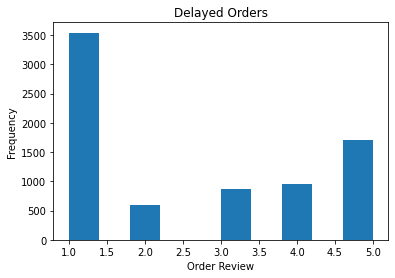

In [164]:
## 65% dos pedidos que atrasam recebem notas menores do que 3

df2_delayed = df2[df2['estimated_minus_delivered']<0]

import matplotlib.pyplot as plt

plt.title('Delayed Orders')
plt.xlabel('Order Review')
plt.ylabel('Frequency')
plt.hist(df2_delayed['review_score'])

df2_delayed['review_score'].value_counts()

5.0    55055
4.0    17947
3.0     7038
1.0     5808
2.0     2320
Name: review_score, dtype: int64

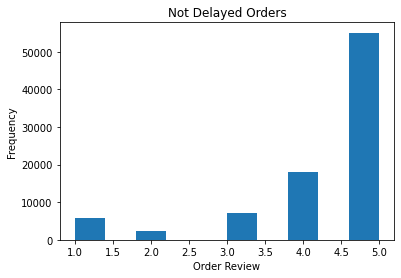

In [165]:
## 83% dos pedidos que não atrasaram receberam nota boa (>=4)

df2_not_delayed = df2[df2['estimated_minus_delivered']>=0]

import matplotlib.pyplot as plt

plt.title('Not Delayed Orders')
plt.xlabel('Order Review')
plt.ylabel('Frequency')
plt.hist(df2_not_delayed['review_score'])

df2_not_delayed['review_score'].value_counts()

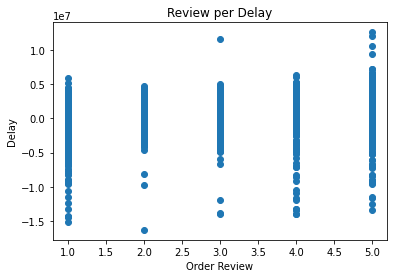

In [167]:
## Não existe relação linear entre quantidade de dias de demora na entrega e nota

plt.scatter(df2['review_score'], df2['estimated_minus_delivered'])
plt.title('Review per Delay')
plt.xlabel('Order Review')
plt.ylabel('Delay')
plt.show()

## Análise 2: Os clientes que dão melhor nota são os clientes que voltam à comprar na Olist?
#### a. Analisar dos que recompraram, quantos deram notas boas
#### b. Analisar dos que não recompraram, quantos deram notas ruins

In [168]:
## Criação de um subset para análise

df3 = {}
df3 = pd.DataFrame().assign(order_id=df['order_id'], customer_unique_id=df['customer_unique_id'], review_score =df['review_score'])
df3.head()


## Vamos excluir os NaN values

df3.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df3.drop_duplicates(subset=['order_id'], inplace=True)

## Criando a coluna de recompra. Caso True, o cliente recomprou na loja Olist

df3['repurchase'] = df3['customer_unique_id'].duplicated()

In [169]:
## Dos que recompraram, temos notas boas (>=4) em 79% dos casos

df3_repurchase_view = df3[df3['repurchase']>0]

df3_repurchase_view['review_score'].value_counts()

5.0    2026
4.0     566
1.0     363
3.0     251
2.0      87
Name: review_score, dtype: int64

In [170]:
## Dos que não recompraram, temos notas boas (>4) em 77% dos casos

df3_not_repurchase_view = df3[df3['repurchase']<=0]

df3_not_repurchase_view['review_score'].value_counts()

#A hipótese é de que o volume de recompra é pequeno (Cerca de 3,3% dentre todo o universo) e, portanto, a análise pode ser inconclusiva devido ao espaço amostral.

## Se olharmos para o setor da olist, temos uma concorrência acirrada. A Olist está interessada em fidelizar os clientes ou está apenas competindo no preço? Entender o objeto (Ver teoria de concorrência perfeita)

5.0    54993
4.0    18478
1.0    10990
3.0     7873
2.0     3046
Name: review_score, dtype: int64

## Análise 3: Nuvem de palavras para as notas consideradas ruins 

In [171]:
df5 = {}
df5 = pd.DataFrame().assign(order_id=df['order_id'], review_score =df['review_score'], review_comment_message=df['review_comment_message'])
df5.head()


## Vamos excluir os NaN values

df5.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df5.drop_duplicates(subset=['order_id'], inplace=True)


## Agora vamos filtrar apenas os comentários de nota baixa

df5_neg_review = df5[df5.review_score<=3]['review_comment_message']
df5_pos_review = df5[df5.review_score>3]['review_comment_message']

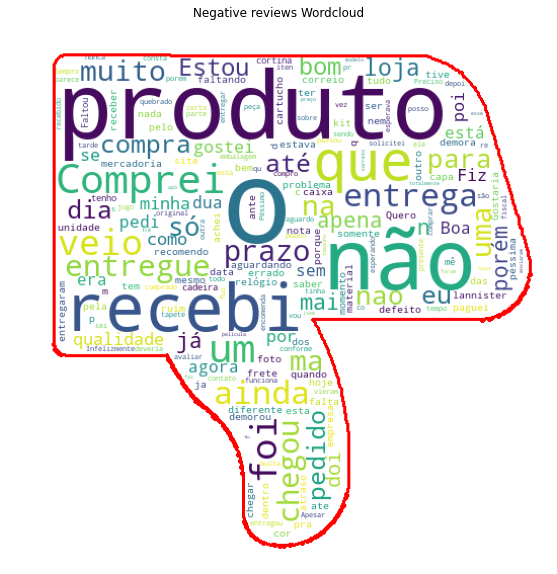

In [172]:
import numpy as np
from PIL import Image
import urllib
from io import BytesIO
import requests
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


# Palavras a serem desconsideradas da análise
stopwords = set(STOPWORDS)
stopwords.update(["/n" ,"da", "meu", "em", "você", "de", "ao", "os", "e", 'ou', 'é'])
 

def open_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_np = np.array(img)
    return img_np

mask = open_img('https://cdn-images-1.medium.com/max/537/1*CK7ulJRe6nqeorManOJUzg.png')


## Gerando a nuvem de palavras
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Reds', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Red',
                      collocations=False, 
                      repeat = False,                   
                      width=700, height=700).generate(df5_neg_review.to_string(index=False))
 
## Configurando visualização da imagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
## Plotando a imagem
plt.title('Negative reviews Wordcloud')
plt.imshow(wordcloudInst)

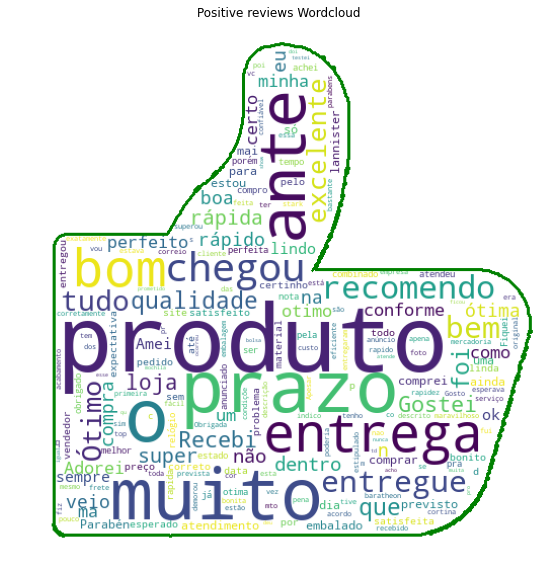

In [173]:
mask = open_img("https://cdn-images-1.medium.com/max/537/1*q4vrNnlsX_d4glglS35AGw.png")


## Gerando a nuvem de palavras
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Greens', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Green',  
                      collocations=False, 
                      repeat = False,    
                      width=700, height=700).generate(df5_pos_review.to_string(index=False))
 
## Configurando visualização da imagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
## Plotando a imagem
plt.title('Positive reviews Wordcloud')
plt.imshow(wordcloudInst)

## Análise 4: Forecasting

In [141]:
df4 = {}
df4 = pd.DataFrame().assign(order_purchase_timestamp=df['order_purchase_timestamp'], price=df['price'], review_score=df['review_score'])
df4.head()

,order_purchase_timestamp,price,review_score
0,2017-10-02 10:56:33,29.99,4.0
1,2018-07-24 20:41:37,118.70,4.0
2,2018-08-08 08:38:49,159.90,5.0
3,2017-11-18 19:28:06,45.00,5.0
4,2018-02-13 21:18:39,19.90,5.0


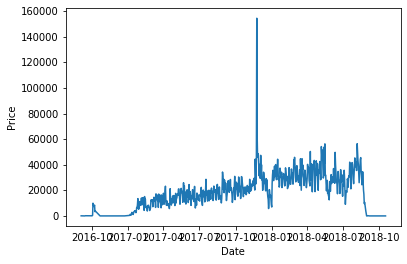

In [142]:
## Plotando o gráfico inicial

etl = Etl(df4)
df4 = etl.date_transformation_and_aggregation()

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

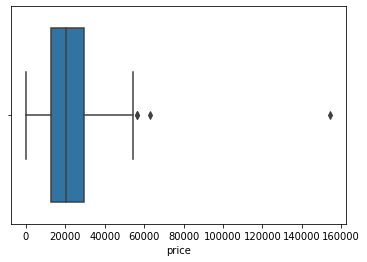

In [143]:
## Boxplot com outliers
sns.boxplot(df4['price'])

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

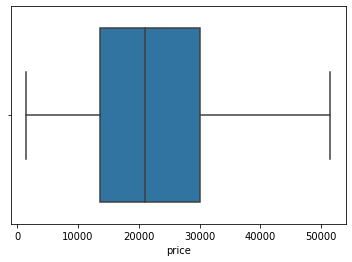

In [147]:
## Boxplot com outliers removidos

etl = Etl(df4)
df4 = etl.remove_outliers(0.99,0.01)
sns.boxplot(df4['price'])

In [57]:
## Main ##

params = Params(df4, 'price')

df4_train, df4_test = params.param_train_test_split()
df4_diff, df4_train_diff, df4_test_diff = params.param_differentiation()

stationarity = Stationarity(df4_train, 'price')
stationarity_diff = Stationarity(df4_train_diff, 'price')

models = Models(df4, 'price')

error = Error(df4, 'price')

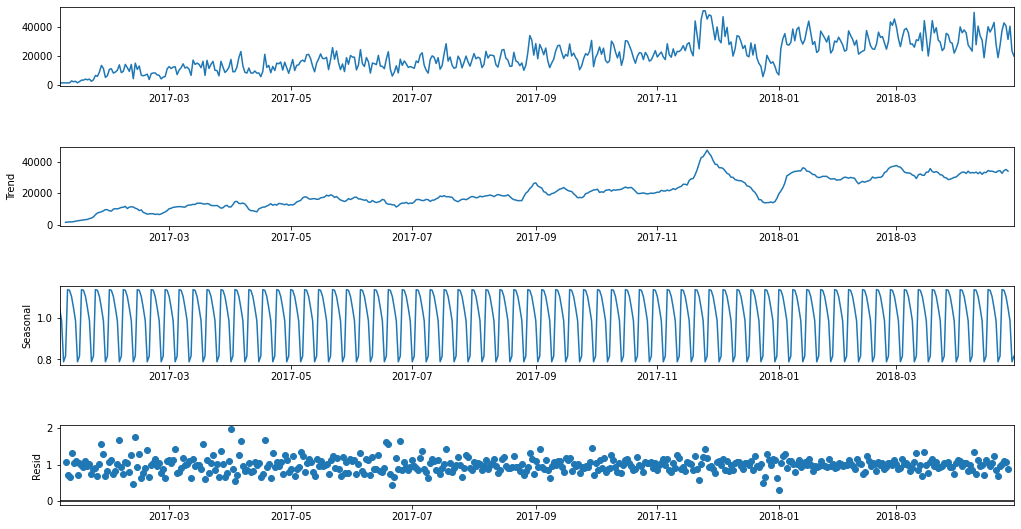

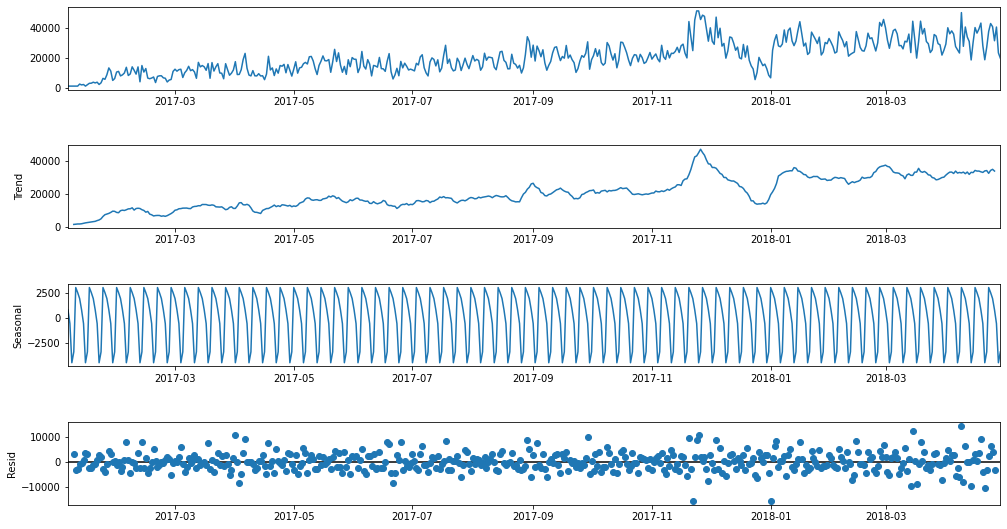

In [32]:
## Explorando tendência, sazonalidade e resíduos do dataset de treino

from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df4_train, model='multiplicative')
fig = season.plot();
fig.set_size_inches(16,8)

season_add = seasonal_decompose(df4_train, model='additive')
fig = season_add.plot();
fig.set_size_inches(16,8)

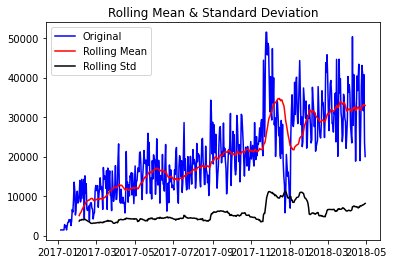

In [33]:
## Defasando para criar a média móvel e o desvio padrão em 30 dias

rolmean = df4_train.rolling(window= 30).mean()
rolstd = df4_train.rolling(window = 30).std()

## Plotando a média móvel

orig = plt.plot(df4_train, color='blue', label = 'Original')
mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [34]:
## Dickey-fuller para o dataset original sem diferenciação

stationarity.dickey_fuller()

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                   -2.308543
p-value                           0.169227
#Lags Used                       15.000000
#Number of observations Used    464.000000
Critical Value (1%)              -3.444522
Critical Value (5%)              -2.867789
Critical Value (10%)             -2.570099
dtype: float64




In [35]:
## Teste KPSS

stationarity.kpss()

KPSS test:

Teste Statistico KPSS       3.1895
Valor-P                     0.0100
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64




C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


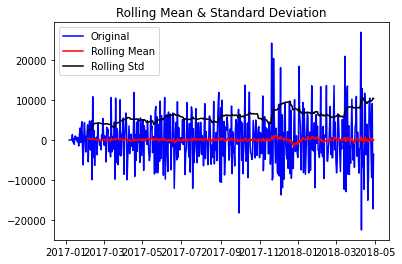

In [37]:
## Diferenciando o dataset original

df4_rolmeandDiff = df4_train_diff.rolling(window= 30).mean()
df4_rolstdDiff = df4_train_diff.rolling(window = 30).std()


## Plotando o dataset diferenciado

orig = plt.plot(df4_train_diff, color='blue', label = 'Original')
mean = plt.plot(df4_rolmeandDiff, color='red', label = 'Rolling Mean')
std = plt.plot(df4_rolstdDiff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [38]:
## Dickey-fuller para o dataset com diferenciaçao

stationarity_diff.dickey_fuller()

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64




In [39]:
## KPSS para o dataset com diferenciação

stationarity_diff.kpss()

KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64




C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### ARIMA - Modelo Original

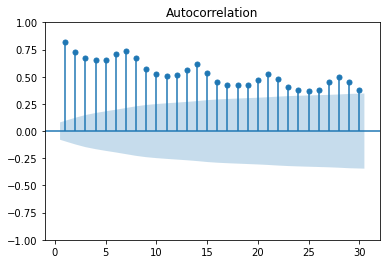

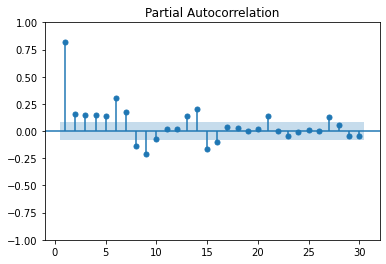

In [44]:
## Determinação do "p" e "q" a partir dos gráficos ACF e PACF

models.acf_and_pacf()

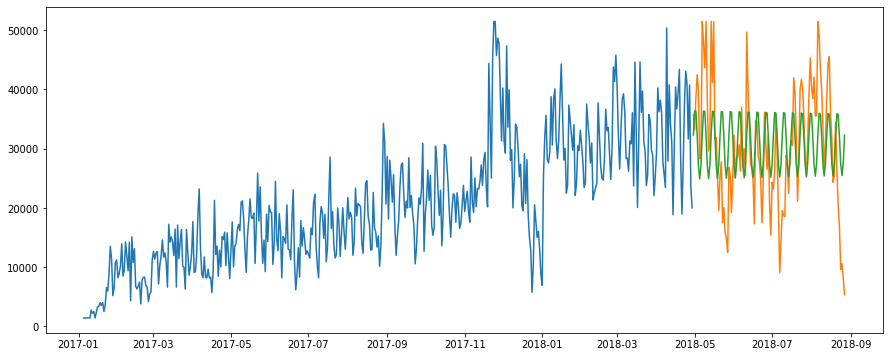

In [45]:
## ARIMA para o modelo original

df4_model, df4_forecast = models.arima_model(2,1,3)

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(df4_forecast)

In [58]:
residual_autocorrelation = ResidualAutocorrelation(df4_model.resid)
residual_normality = ResidualNormality(df4_model.resid)
heteroskedasticity = Heteroskedasticity(df4_train, df4_model.resid)
stationarity = Stationarity(df4_train_diff, 'price')

error.rmse(df4_forecast)
error.mae(df4_forecast)
stationarity.dickey_fuller()
stationarity.kpss()
stationarity.augmented_dickey_fuller()
stationarity.phillips_perron()
residual_autocorrelation.ljung_box()
residual_autocorrelation.durbin_watson()
residual_normality.ks_test()
residual_normality.jarque_bera()
heteroskedasticity.arch_test()

Root Mean Square Error:

9247.596954839624
Mean Absolute Error:

7324.119574157119
Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


(-6.615837341651585, 6.210773211483446e-09, 15, 463, {'1%': -3.44455286264131, '5%': -2.8678027030003483, '10%': -2.5701057817594894}, 9164.416297712407)


     Phillips-Perron Test (Z-tau)    
Test Statistic                -44.587
P-value                         0.0

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


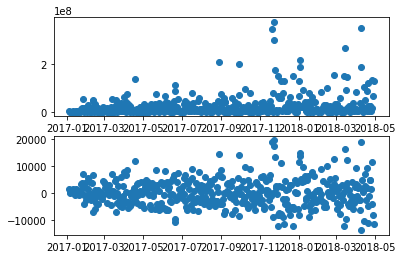

In [59]:
## Plot Erro quadrático médio

heteroskedasticity.plot_error()

### ARIMA - Transformação Logarítmica

In [62]:
## Main ##

df4_log = np.log(df4)

params_log = Params(df4_log, 'price')

df4_log_train, df4_log_test = params_log.param_train_test_split()
df4_log_diff, df4_log_train_diff, df4_log_test_diff = params_log.param_differentiation()

stationarity_log = Stationarity(df4_log_train, 'price')
stationarity_log_diff = Stationarity(df4_log_train_diff, 'price')

models_log = Models(df4_log, 'price')

error_log = Error(df4_log, 'price')

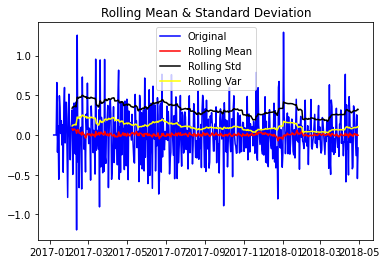

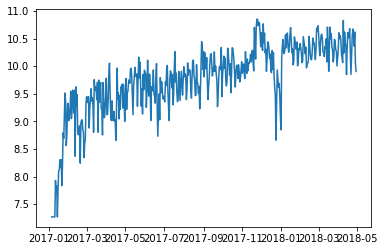

In [63]:
## ARIMA com transformação logarítmica

##Transformando o dataset

rolmeandDiffLog = df4_log_train_diff.rolling(window= 30).mean()
rolstdDiffLog = df4_log_train_diff.rolling(window = 30).std()
rolvarDiffLog = df4_log_train_diff.rolling(window = 30).var()

## Plotando o dataset transformado e diferenciado

orig = plt.plot(df4_log_train_diff, color='blue', label = 'Original')
mean = plt.plot(rolmeandDiffLog, color='red', label = 'Rolling Mean')
std = plt.plot(rolstdDiffLog, color='black', label = 'Rolling Std')
std = plt.plot(rolvarDiffLog, color='yellow', label = 'Rolling Var')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

plt.plot(df4_log_train)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


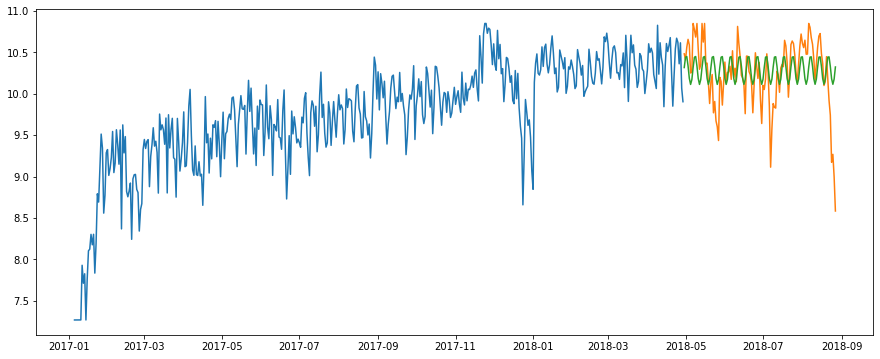

In [64]:
## ARIMA para o modelo com transformação logarítmica

df4_log_model, df4_log_forecast = models_log.arima_model(2,1,3)

plt.figure(figsize=(15, 6))
plt.plot(df4_log_train.price)
plt.plot(df4_log_test)
plt.plot(df4_log_forecast)

In [66]:
## Analisando resultados

forecast_log = np.exp(df4_log_forecast)
df4_log_test = np.exp(df4_log_test)

residual_autocorrelation_log = ResidualAutocorrelation(df4_log_model.resid)
residual_normality_log = ResidualNormality(df4_log_model.resid)
heteroskedasticity_log = Heteroskedasticity(df4_log_train, df4_log_model.resid)
stationarity_log = Stationarity(df4_log_train_diff, 'price')

error.rmse(forecast_log)
error.mae(forecast_log)
stationarity_log.dickey_fuller()
stationarity_log.kpss()
stationarity_log.augmented_dickey_fuller()
stationarity_log.phillips_perron()
residual_autocorrelation_log.ljung_box()
residual_autocorrelation_log.durbin_watson()
residual_normality_log.ks_test()
residual_normality_log.jarque_bera()
heteroskedasticity_log.arch_test()

Root Mean Square Error:

9287.238430168605
Mean Absolute Error:

7395.953368491271
Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.146155e+00
p-value                         7.758427e-08
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.4192
Valor-P                      0.0689
Lags Usados                233.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


(-6.146154891852863, 7.758426568565219e-08, 15, 463, {'1%': -3.44455286264131, '5%': -2.8678027030003483, '10%': -2.5701057817594894}, 97.66771133633233)


     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.254
P-value                     

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


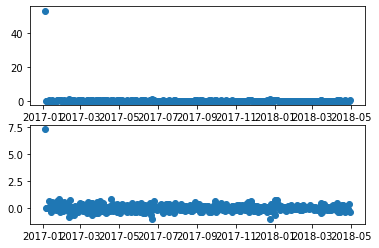

In [67]:
## Plot Erro quadrático médio

heteroskedasticity_log.plot_error()

### Avaliação Box-Cox 

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

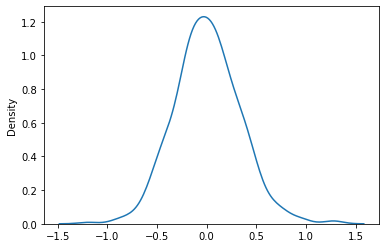

In [69]:
## Avaliar box-cox

import numpy as np 
from scipy.stats import boxcox 
import seaborn as sns 

sns.distplot(df4_log_train_diff, hist=False, kde=True) 

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='boxcox', ylabel='Density'>

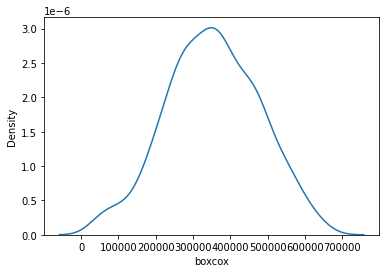

In [70]:
## Transformação box-cox

df4_log_train['boxcox'], best_lambda = boxcox(df4_log_train['price']) 

sns.distplot(df4_log_train['boxcox'], hist=False, kde=True)

### SARIMA - Modelo Original

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


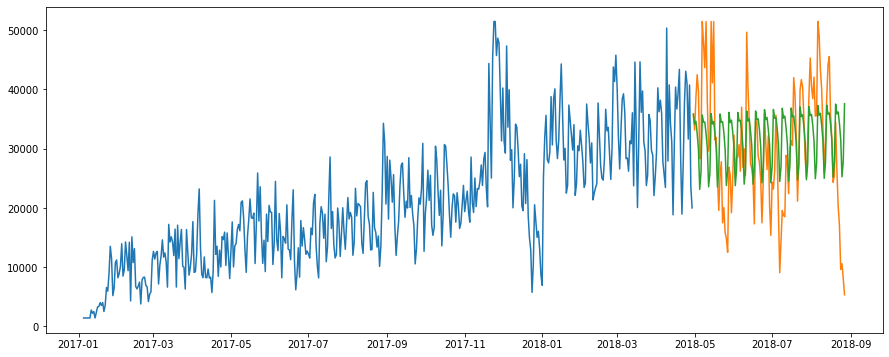

In [72]:
## Sarima para o modelo original

df4_sarima_model, df4_sarima_forecast = models.sarima_model(1, 1, 2, 2, 1, 1)

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(df4_sarima_forecast)


# Combinação: (1,1,2) (2,1,1,7) RMSE: 9239.11 


In [73]:
## Summary do modelo

residual_autocorrelation = ResidualAutocorrelation(df4_sarima_model.resid)
residual_normality = ResidualNormality(df4_sarima_model.resid)
heteroskedasticity = Heteroskedasticity(df4_train, df4_sarima_model.resid)
stationarity_log = Stationarity(df4_train_diff, 'price')

error.rmse(df4_sarima_forecast)
error.mae(df4_sarima_forecast)
stationarity.dickey_fuller()
stationarity.kpss()
stationarity.augmented_dickey_fuller()
stationarity.phillips_perron()
residual_autocorrelation.ljung_box()
residual_autocorrelation.durbin_watson()
residual_normality.ks_test()
residual_normality.jarque_bera()
heteroskedasticity.arch_test()

Root Mean Square Error:

9239.115956617174
Mean Absolute Error:

7212.81006371878
Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


(-6.615837341651585, 6.210773211483446e-09, 15, 463, {'1%': -3.44455286264131, '5%': -2.8678027030003483, '10%': -2.5701057817594894}, 9164.416297712407)


     Phillips-Perron Test (Z-tau)    
Test Statistic                -44.587
P-value                         0.00

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


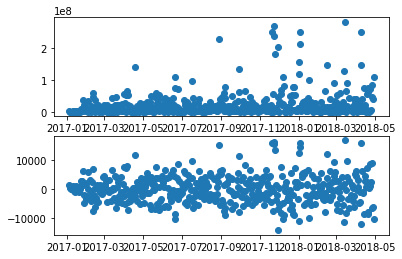

In [74]:
## Plot Erro quadrático médio

heteroskedasticity.plot_error()

### SARIMA - Transformação Logarítmica 

In [78]:
## Main ##

df4_log = np.log(df4)

params_log = Params(df4_log, 'price')

df4_log_train, df4_log_test = params_log.param_train_test_split()
df4_log_diff, df4_log_train_diff, df4_log_test_diff = params_log.param_differentiation()

stationarity_log = Stationarity(df4_log_train, 'price')
stationarity_log_diff = Stationarity(df4_log_train_diff, 'price')

models_log = Models(df4_log, 'price')

error_log = Error(df4_log, 'price')

df4_log_model, df4_log_forecast = models_log.arima_model(2,1,3)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


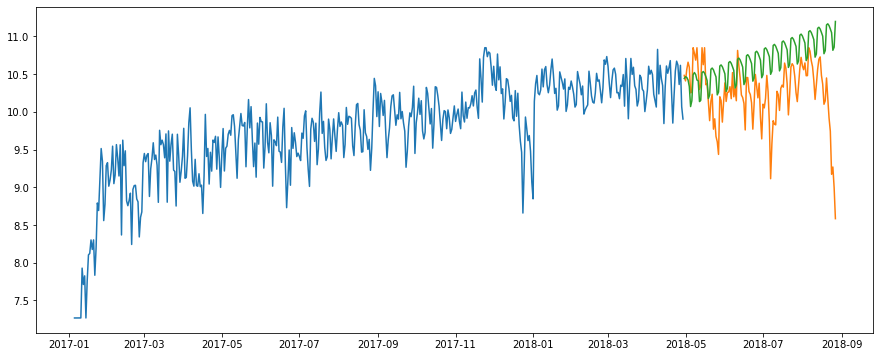

In [79]:
## Sarima para o modelo com transformção logarítmica

df4_log_sarima_model, df4_log_sarima_forecast = models_log.sarima_model(1, 1, 2, 2, 1, 1)

plt.figure(figsize=(15, 6))
plt.plot(df4_log_train.price)
plt.plot(df4_log_test)
plt.plot(df4_log_sarima_forecast)

## Resultados:

## RMSE: 9764.957263578564 order = (10 ,1, 4),seasonal_order=(6, 1, 2, 30)
## RMSE: 11509.113274808042 order = (13 ,1, 8),seasonal_order=(6, 1, 2, 30)
## RMSE: 18838.95621248338  order = (13 ,1, 8),seasonal_order=(6, 1, 3, 30)
## RMSE: 15353.766193912934 order = (10 ,1, 4),seasonal_order=(6, 1, 3, 30)
## RMSE: 9950.505437483987 order = (10 ,1, 4),seasonal_order=(7, 1, 2, 30)
## RMSE: 15281.772681373654 order = (10 ,1, 4),seasonal_order=(5, 1, 2, 30)
## RMSE: 9770.653750812133 order = (10 ,1, 4),seasonal_order=(8, 1, 2, 30))
## RMSE: 10020.933488790599 order = (10 ,1, 4),seasonal_order=(9, 1, 2, 30)
## RMSE: 11173.787394506411 order = (1 ,1, 1),seasonal_order=(6, 1, 2, 30)

In [82]:
## Analisando resultados

forecast_log_sarima = np.exp(df4_log_sarima_forecast)

residual_autocorrelation_log_sarima = ResidualAutocorrelation(df4_log_sarima_model.resid)
residual_normality_log_sarima = ResidualNormality(df4_log_sarima_model.resid)
heteroskedasticity_log_sarima = Heteroskedasticity(df4_log_train, df4_log_sarima_model.resid)
stationarity_log_sarima = Stationarity(df4_log_train_diff, 'price')

error.rmse(forecast_log_sarima)
error.mae(forecast_log_sarima)
stationarity_log_sarima.dickey_fuller()
stationarity_log_sarima.kpss()
stationarity_log_sarima.augmented_dickey_fuller()
stationarity_log_sarima.phillips_perron()
residual_autocorrelation_log_sarima.ljung_box()
residual_autocorrelation_log_sarima.durbin_watson()
residual_normality_log_sarima.ks_test()
residual_normality_log_sarima.jarque_bera()
heteroskedasticity_log_sarima.arch_test()

Root Mean Square Error:

20487.809627879433
Mean Absolute Error:

17086.841212871113
Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.146155e+00
p-value                         7.758427e-08
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.4192
Valor-P                      0.0689
Lags Usados                233.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


(-6.146154891852863, 7.758426568565219e-08, 15, 463, {'1%': -3.44455286264131, '5%': -2.8678027030003483, '10%': -2.5701057817594894}, 97.66771133633233)


     Phillips-Perron Test (Z-tau)    
Test Statistic                -43.254
P-value                   

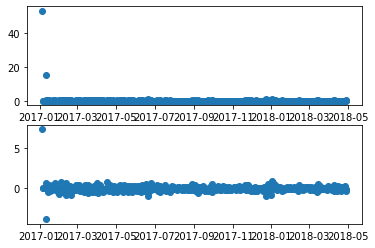

In [83]:
## Plot Erro quadrático médio

heteroskedasticity_log_sarima.plot_error()

### SARIMA - Notas 4 e 5  

C:\Users\valeria\AppData\Local\Temp\ipykernel_2760\3549357864.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
C:\Users\valeria\AppData\Local\Temp\ipykernel_2760\3549357864.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.date


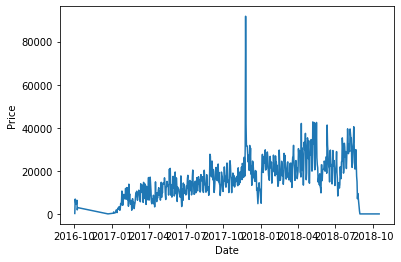

In [148]:
## Criando o dataset

df6 = {}
df6 = pd.DataFrame().assign(order_purchase_timestamp=df['order_purchase_timestamp'], price=df['price'], review_score=df['review_score'])
df6.head()

df7 = df6[df6['review_score']>3]


etl = Etl(df7)
df7 = etl.date_transformation_and_aggregation()

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

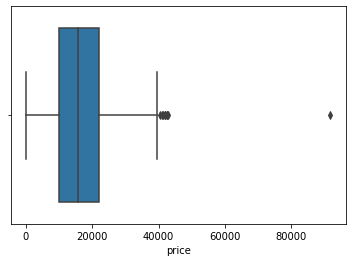

In [149]:
## Boxplot com outliers
sns.boxplot(df7['price'])

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

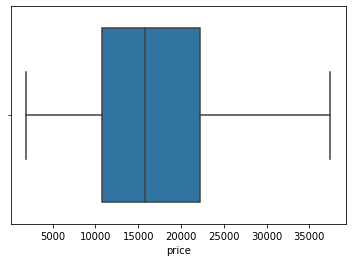

In [151]:
## Boxplot com outliers removidos

etl = Etl(df7)
df7 = etl.remove_outliers(0.98,0.02)
sns.boxplot(df7['price'])

In [89]:
## Main ##

params_df7 = Params(df7, 'price')

df7_train, df7_test = params_df7.param_train_test_split()
df7_diff, df7_train_diff, df7_test_diff = params_df7.param_differentiation()

stationarity_df7 = Stationarity(df7, 'price')
stationarity_diff_df7 = Stationarity(df7_diff, 'price')

models_df7 = Models(df7, 'price')

error_df7 = Error(df7, 'price')

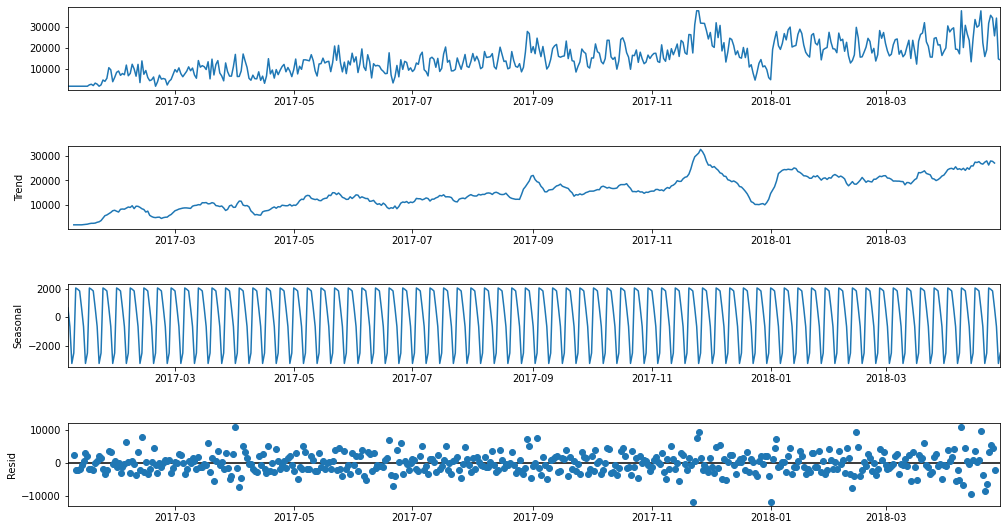

In [90]:
## Plotando tendência, sazonalidade e resíduos

from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df7_train)
fig = season.plot();
fig.set_size_inches(16,8)

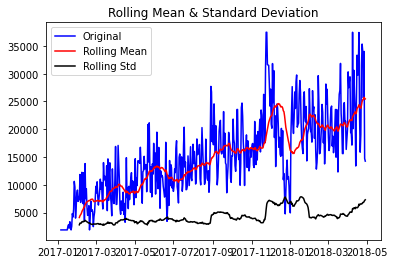

In [91]:
## Defasando para criar a média móvel e o desvio padrão em 30 dias

rolmean = df7_train.rolling(window= 30).mean()
rolstd = df7_train.rolling(window = 30).std()

## Plotando a média móvel

orig = plt.plot(df7_train, color='blue', label = 'Original')
mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [73]:
## Teste de Dickey-Fuller

stationarity_df7.dickey_fuller()

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                   -2.404564
p-value                           0.140452
#Lags Used                       15.000000
#Number of observations Used    464.000000
Critical Value (1%)              -3.444522
Critical Value (5%)              -2.867789
Critical Value (10%)             -2.570099
dtype: float64


In [93]:
## Teste KPSS

stationarity_df7.kpss()

KPSS test:

Teste Statistico KPSS       2.9874
Valor-P                     0.0100
Lags Usados                15.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64




C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


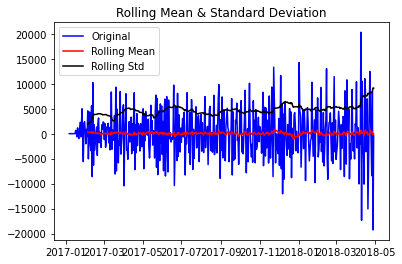

In [96]:
##Diferenciando a série

df7_rolmeandDiff = df7_train_diff.rolling(window= 30).mean()
df7_rolstdDiff = df7_train_diff.rolling(window = 30).std()


## Plotando a diferenciação

orig = plt.plot(df7_train_diff, color='blue', label = 'Original')
mean = plt.plot(df7_rolmeandDiff, color='red', label = 'Rolling Mean')
std = plt.plot(df7_rolstdDiff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


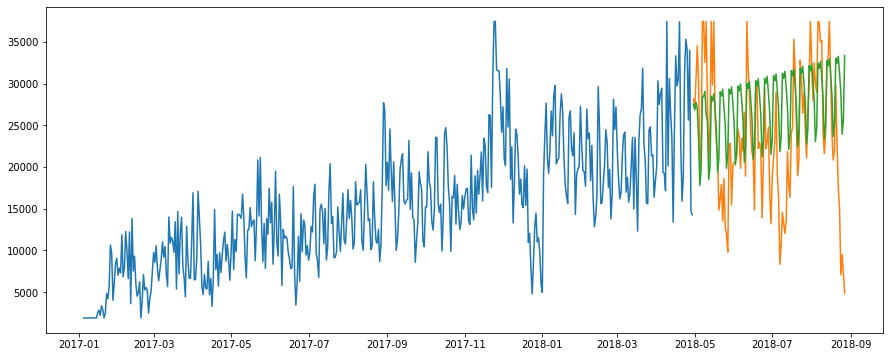

In [97]:
## Sarima para o modelo original

df7_sarima_model, df7_sarima_forecast = models_df7.sarima_model(1, 1, 2, 2, 1, 1)

plt.figure(figsize=(15, 6))
plt.plot(df7_train.price)
plt.plot(df7_test)
plt.plot(df7_sarima_forecast)

In [99]:
## Summary do modelo

residual_autocorrelation_df7 = ResidualAutocorrelation(df7_sarima_model.resid)
residual_normality_df7 = ResidualNormality(df7_sarima_model.resid)
heteroskedasticity_df7 = Heteroskedasticity(df7_train, df7_sarima_model.resid)
stationarity_df7 = Stationarity(df7_train_diff, 'price')

error.rmse(df7_sarima_forecast)
error.mae(df7_sarima_forecast)
stationarity_df7.dickey_fuller()
stationarity_df7.kpss()
stationarity_df7.augmented_dickey_fuller()
stationarity_df7.phillips_perron()
residual_autocorrelation_df7.ljung_box()
residual_autocorrelation_df7.durbin_watson()
residual_normality_df7.ks_test()
residual_normality_df7.jarque_bera()
heteroskedasticity_df7.arch_test()

Root Mean Square Error:

9868.06189019985
Mean Absolute Error:

7804.097349455892
Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.340439e+00
p-value                         2.763242e-08
#Lags Used                      1.400000e+01
#Number of observations Used    4.640000e+02
Critical Value (1%)            -3.444522e+00
Critical Value (5%)            -2.867789e+00
Critical Value (10%)           -2.570099e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.2928
Valor-P                      0.1000
Lags Usados                149.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


(-6.340438822945928, 2.7632419799966486e-08, 14, 464, {'1%': -3.4445220811896657, '5%': -2.8677891615873192, '10%': -2.5700985643950656}, 8938.836128031644)


     Phillips-Perron Test (Z-tau)    
Test Statistic                -46.324
P-value                   

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


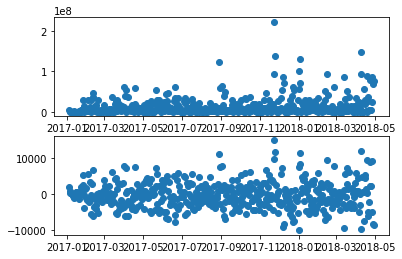

In [100]:
## Plot Erro quadrático médio

heteroskedasticity_df7.plot_error()

### Comparando resultados para notas boas/ruins e notas boas  

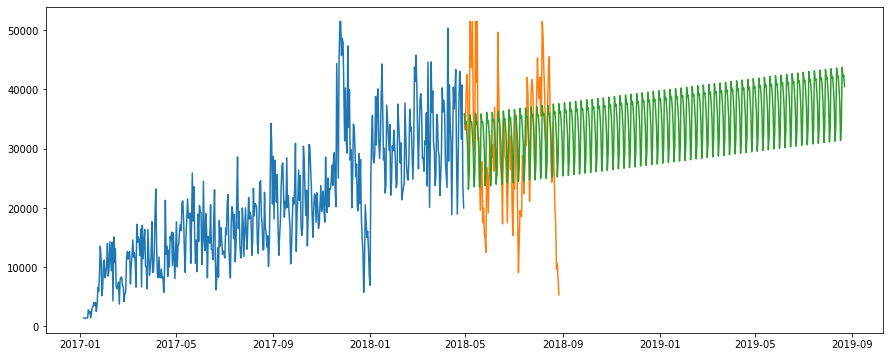

In [102]:
## Forecast para notas boas e ruins

forecast_all = df4_sarima_model.forecast(steps=480)

forecast_all = forecast_all.loc['2018-04-30':'2019-08-22']

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(forecast_all)

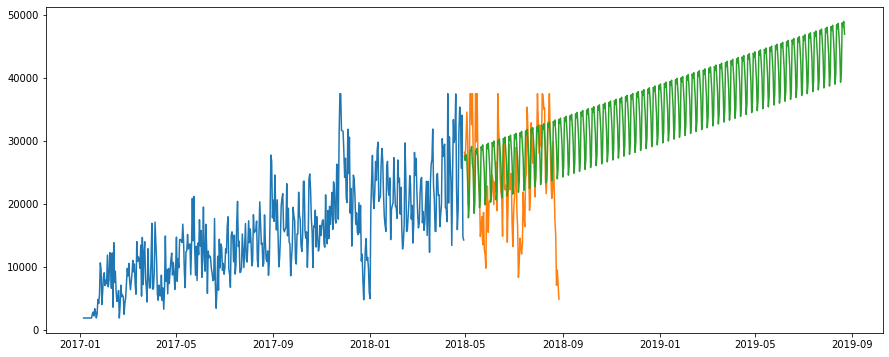

In [103]:
##Forecast para notas boas

forecast_best_scores = df7_sarima_model.forecast(steps=480)

forecast_best_scores = forecast_best_scores.loc['2018-04-30':'2019-08-22']

plt.figure(figsize=(15, 6))
plt.plot(df7_train.price)
plt.plot(df7_test)
plt.plot(forecast_best_scores)

In [104]:
## Soma da receita para notas boas e ruins

forecast_all.sum()

16715153.58239673

In [105]:
## Soma da receita para notas boas

forecast_best_scores.sum()

16862636.59895118